## Fit PDF


In [15]:
# load csv
import pandas as pd

df = pd.read_csv('../customer_support_tickets.csv')

In [16]:
# drop first response time Null/Nan and Time to resolution NaN/Null
df.dropna(inplace=True)

df['First Response Time'] = df['First Response Time'].apply(lambda x: x.replace(' ', 'T').strip())
df['Time to Resolution'] = df['Time to Resolution'].apply(lambda x: x.replace(' ', 'T').strip())


In [17]:
# convert to datetime
df['First Response Time'] = pd.to_datetime(df['First Response Time'])
df['Time to Resolution'] = pd.to_datetime(df['Time to Resolution'])

In [18]:
# remove where 'First Response Time' is greater or equal than 'Time to Resolution'
df = df[df['First Response Time'] < df['Time to Resolution']]

In [19]:
df.head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0
19,20,Jeffrey Robertson,jameslopez@example.com,39,Female,Canon EOS,2021-03-08,Refund request,Software bug,I'm having an issue with the {product_purchase...,Closed,Wish mouth build resource though.,Low,Chat,2023-06-01 00:46:04,2023-06-01 20:29:04,5.0
28,29,Christine Wang,garciastacy@example.com,30,Other,Fitbit Charge,2020-06-10,Technical issue,Product recommendation,I'm having an issue with the {product_purchase...,Closed,Soldier we such inside.,Critical,Phone,2023-05-31 23:17:17,2023-06-01 06:03:17,5.0
29,30,Austin George,shericase@example.net,67,Male,Xbox,2020-12-26,Cancellation request,Cancellation request,I'm having an issue with the {product_purchase...,Closed,Firm sort voice above which site arrive.,Medium,Phone,2023-06-01 00:54:17,2023-06-01 18:23:17,1.0


In [21]:
data = pd.DataFrame()
data['First Response Time'] = df['First Response Time']
# we only care about the minutes
data.sort_values(by='First Response Time', inplace=True)
data['time_diff_minutes'] = data['First Response Time'].diff().dt.total_seconds()
data['time_diff_minutes'] = data['time_diff_minutes'].fillna(0)
data.head()

,First Response Time,time_diff_minutes
395,2023-05-31 21:55:39,0.0
765,2023-05-31 22:06:18,639.0
128,2023-05-31 22:12:33,375.0
371,2023-05-31 22:20:05,452.0
418,2023-05-31 22:20:10,5.0


In [22]:
data['time_diff_minutes'].describe()

count    1402.000000
mean       66.002140
std       124.981892
min         0.000000
25%        14.000000
50%        37.000000
75%        79.000000
max      3165.000000
Name: time_diff_minutes, dtype: float64

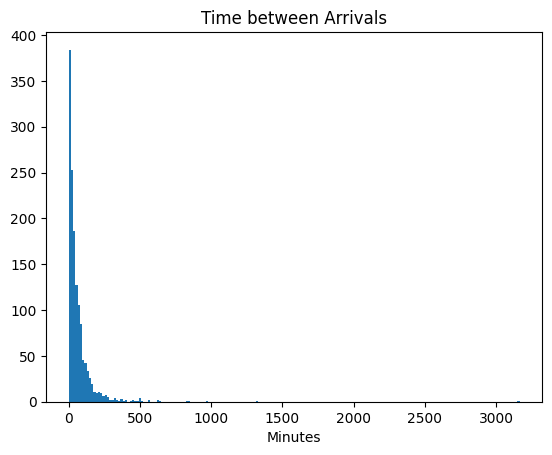

In [23]:
import matplotlib.pyplot as plt

plt.title('Time between Arrivals')
plt.xlabel('Minutes')
plt.hist(data['time_diff_minutes'], bins=200)
plt.show()

In [25]:
from scipy import stats
import numpy as np

# Removing outliers using a z-score of 3
removed_outliers = data[(np.abs(stats.zscore(data['time_diff_minutes'])) < 3)]

removed_outliers['time_diff_minutes'].describe()

count    1383.000000
mean       56.407086
std        63.145376
min         0.000000
25%        14.000000
50%        36.000000
75%        75.000000
max       432.000000
Name: time_diff_minutes, dtype: float64

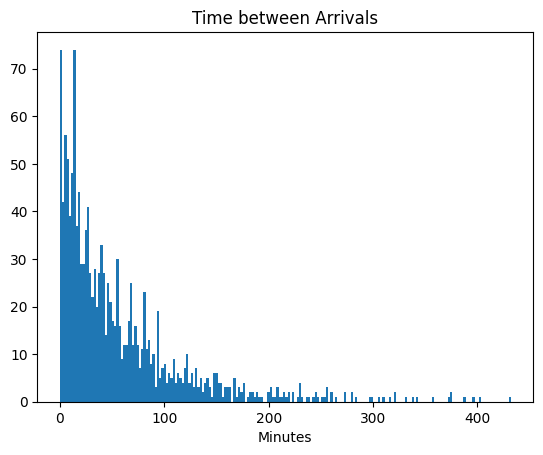

In [26]:
plt.title('Time between Arrivals')
plt.xlabel('Minutes')
plt.hist(removed_outliers['time_diff_minutes'], bins=200)
plt.show()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
pareto,0.000051,1531.906729,1547.602760,inf,0.025593,0.319909
truncpareto,0.000051,1528.427338,1549.355379,inf,0.027519,0.241320
burr12,0.000052,1541.676182,1562.604224,inf,0.019345,0.671298
halfgennorm,0.000052,1530.811244,1546.507275,inf,0.018869,0.700969
recipinvgauss,0.000058,1521.260629,1536.956660,inf,0.024561,0.368570


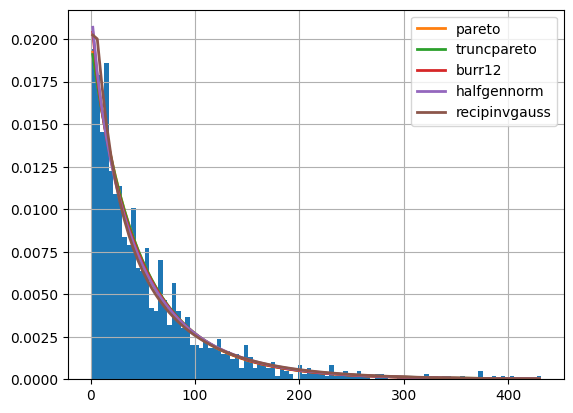

In [27]:
from fitter import Fitter

f = Fitter(removed_outliers['time_diff_minutes'])
f.fit()
# may take some time since by default, all distributions are tried,
# but you call manually provide a smaller set of distributions
f.summary()

In [28]:
best_params_arrivals = f.get_best(method='sumsquare_error')
print(best_params_arrivals)

{'pareto': {'b': 8.081771083639762, 'loc': -400.05903534867156, 'scale': 400.0590353486715}}


In [29]:
ia = stats.pareto.rvs(**best_params_arrivals.get('pareto'), size=4_000)

gen = pd.DataFrame()
gen['ia'] = ia

In [30]:
gen.head()

,ia
0,20.641087
1,176.565345
2,53.790749
3,111.486454
4,47.775260


In [31]:
gen['ia'].describe()

count    4000.000000
mean       57.744352
std        67.873509
min         0.000406
25%        15.205413
50%        36.342264
75%        75.209617
max       872.089996
Name: ia, dtype: float64

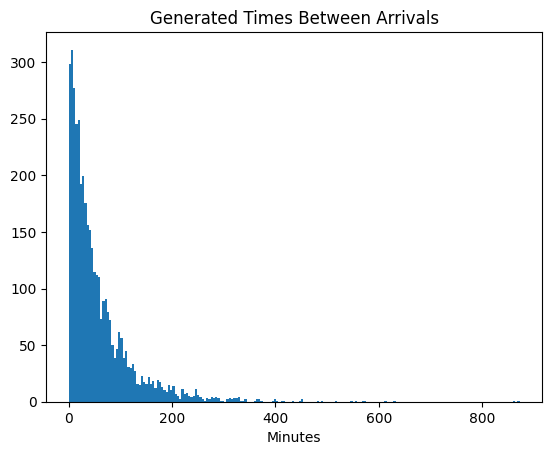

In [32]:
plt.title('Generated Times Between Arrivals')
plt.xlabel('Minutes')
plt.hist(gen['ia'], bins=200)
plt.show()

In [33]:
# same for resolution time
data = pd.DataFrame()
data['Time to Resolution'] = df['Time to Resolution']
data['First Response Time'] = df['First Response Time']
data['delta'] = data['Time to Resolution'] - data['First Response Time']
data['ta_minutes'] = data['delta'].apply(lambda x: x.total_seconds() / 60)

In [34]:
data['ta_minutes'].head()

2      411.0
4     1181.0
19    1183.0
28     406.0
29    1049.0
Name: ta_minutes, dtype: float64

In [35]:
data['ta_minutes'].describe()

count    1402.000000
mean      455.324536
std       335.597811
min         1.000000
25%       180.000000
50%       382.500000
75%       681.750000
max      1408.000000
Name: ta_minutes, dtype: float64

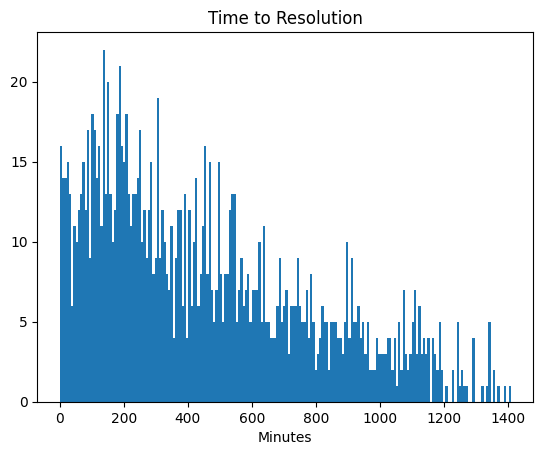

In [37]:
plt.title('Time to Resolution')
plt.xlabel('Minutes')
plt.hist(data['ta_minutes'], bins=200)
plt.show()

In [46]:
resolution_outliers = data[(np.abs(stats.zscore(data['ta_minutes'])) < 2.5)]
resolution_outliers['ta_minutes'].describe()

count    1389.000000
mean      446.962563
std       325.771819
min         1.000000
25%       180.000000
50%       378.000000
75%       668.000000
max      1292.000000
Name: ta_minutes, dtype: float64

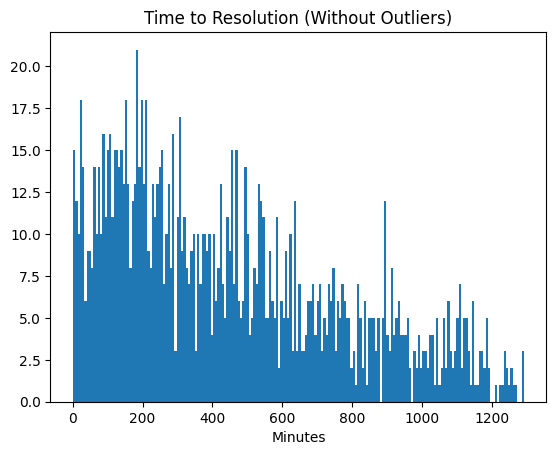

In [47]:
plt.title('Time to Resolution (Without Outliers)')
plt.xlabel('Minutes')
plt.hist(resolution_outliers['ta_minutes'], bins=200)
plt.show()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gausshyper,0.000004,1480.520469,1511.938505,0.039121,0.018379,0.728803
triang,0.000005,1480.695842,1496.404860,0.041712,0.031993,0.113948
halfnorm,0.000005,1494.129273,1504.601952,0.043940,0.029252,0.181901
skewnorm,0.000005,1495.998573,1511.707591,0.043984,0.029277,0.181178
genpareto,0.000005,1479.511572,1495.220590,0.042298,0.036089,0.052363


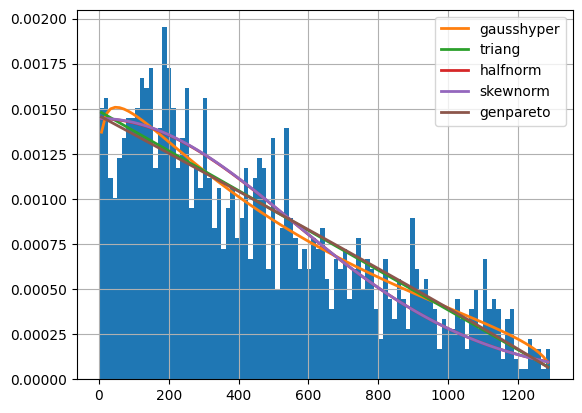

In [48]:
f = Fitter(resolution_outliers['ta_minutes'])
f.fit()
f.summary()

In [50]:
# The best fit is the gausshyper distribution, but we can also try the argus distribution
best_params_arrivals = f.get_best(method='sumsquare_error')
print(best_params_arrivals)

{'gausshyper': {'a': 1.0849480846709834, 'b': 1.3832003644016413, 'c': 1.9794855101439612, 'z': 0.982926014368478, 'loc': 0.9477414716993133, 'scale': 1296.2750378147014}}


In [53]:
ta = stats.gausshyper.rvs(**best_params_arrivals.get('gausshyper'), size=4_000)
gen['ta'] = ta
gen['ta'].describe()

count    4000.000000
mean      465.415193
std       329.221805
min         0.966324
25%       191.855113
50%       406.020419
75%       691.847526
max      1290.303588
Name: ta, dtype: float64

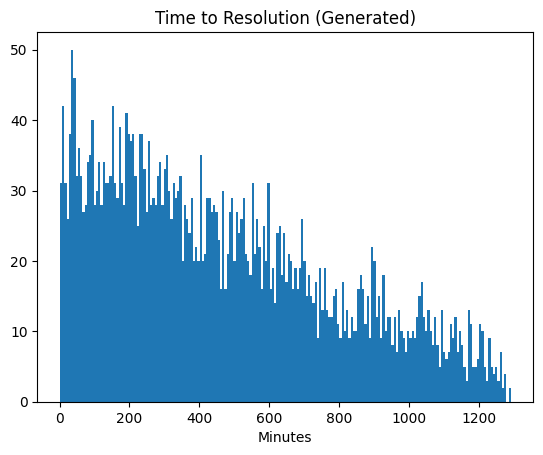

In [54]:
plt.title('Time to Resolution (Generated)')
plt.xlabel('Minutes')
plt.hist(gen['ta'], bins=200)
plt.show()

In [55]:
df['Ticket Priority'] = df['Ticket Priority'].apply(lambda x: x.strip()).astype('category')

In [56]:
df['Ticket Priority'].value_counts() / df['Ticket Priority'].count() * 100

Ticket Priority
Critical    26.676177
High        25.320970
Medium      24.322397
Low         23.680456
Name: count, dtype: float64